In [1]:
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import numpy

In [3]:
from result.ldc_2d_benchmark_P100  import ldc_2d_p100
from result.ldc_2d_benchmark_K2200 import ldc_2d_k2200
from result.ldc_3d_benchmark_P100  import ldc_3d_p100
from result.ldc_3d_benchmark_K2200 import ldc_3d_k2200

In [4]:
ldc_2d_k2200[0]

((32, (32, 1), 'double', False, True), [15, 16, 15, 16, 16])

In [5]:
ldc_3d_k2200[1]

((64, (64, 1, 1), 'symbolic.D3Q19', 'single', True, True),
 [421, 422, 421, 421, 421])

In [6]:
p100_max_bandwidth = 512.6*1024**3
k2200_max_bandwidth = 63.2*1024**3

In [7]:
def max_mlups(b, q, precision):
    return b / ((2*q*precision+4)*10**6)

In [8]:
max_mlups(k2200_max_bandwidth, 27, 4)

308.45674216727275

In [9]:
def descriptor_subset(data, descriptor):
    return list(
        map(lambda m: (m[0][0:2] + m[0][3:], m[1]),
            filter(lambda m: m[0][2] == descriptor, data)))

In [10]:
ldc_3d_D3Q19_p100  = descriptor_subset(ldc_3d_p100,  'symbolic.D3Q19')
ldc_3d_D3Q27_p100  = descriptor_subset(ldc_3d_p100,  'symbolic.D3Q27')
ldc_3d_D3Q19_k2200 = descriptor_subset(ldc_3d_k2200, 'symbolic.D3Q19')
ldc_3d_D3Q27_k2200 = descriptor_subset(ldc_3d_k2200, 'symbolic.D3Q27')

In [11]:
def values(data, index):
    return set(map(lambda m: m[0][index], data))

In [12]:
values(ldc_3d_D3Q19_k2200, 0)

{10, 16, 20, 32, 40, 48, 60, 64, 80, 96, 100, 128}

In [13]:
def has(value, options):
    if options == None:
        return True
    elif callable(options):
        return options(value)
    else:
        return value in options

def subset(data, size=None, layout=None, precision=None, optimization=None, align=None):
    return list(
        filter(lambda m: has(m[0][0], size) and
               has(m[0][1][0], layout) and
               has(m[0][2], precision) and
               has(m[0][3], optimization) and
               has(m[0][4], align),
               data))

In [14]:
def mlups_for_size(measurement):
    dim = len(list(measurement[0][1]))
    return (measurement[0][0]**dim, numpy.average(measurement[1]))

In [15]:
def scatter(data, **kwargs):
    plt.scatter(*zip(*list(data)), **kwargs)

In [16]:
def mlups_per_size_overview_plot(data, title, **kwargs):
    plt.figure(figsize=(11,7.5))
    plt.grid()
    plt.title(title)
    plt.xscale('log')
    plt.xlabel('Cells')
    plt.ylabel('MLUPS')
    plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%4d'))
    scatter(map(mlups_for_size, subset(data, precision=['single'], optimization=[True], **kwargs)), label='single, CSE', s=16)
    scatter(map(mlups_for_size, subset(data, precision=['double'], optimization=[True], **kwargs)), label='double, CSE', s=16)
    scatter(map(mlups_for_size, subset(data, precision=['single'], optimization=[False], **kwargs)), label='single, not-CSE', s=16)
    scatter(map(mlups_for_size, subset(data, precision=['double'], optimization=[False], **kwargs)), label='double, not-CSE', s=16)
    plt.legend()

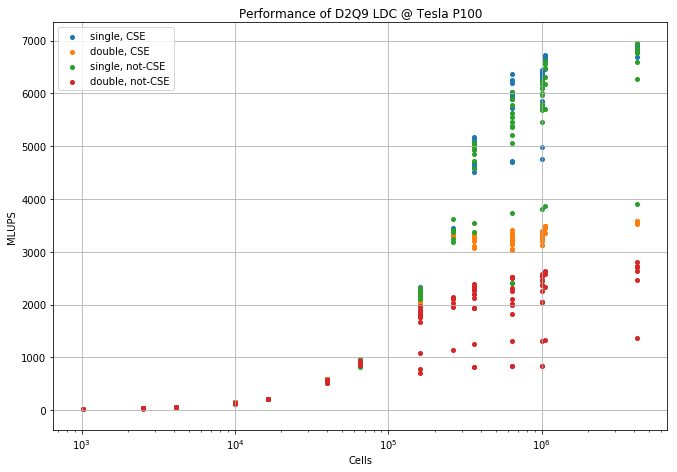

In [17]:
mlups_per_size_overview_plot(ldc_2d_p100, 'Performance of D2Q9 LDC @ Tesla P100')
plt.savefig('overview_d2q9_p100.pdf', bbox_inches='tight')

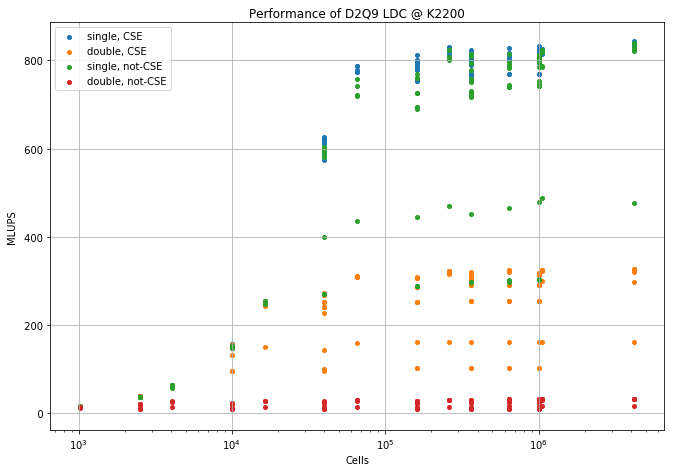

In [18]:
mlups_per_size_overview_plot(ldc_2d_k2200, 'Performance of D2Q9 LDC @ K2200')
plt.savefig('overview_d2q9_k2200.pdf', bbox_inches='tight')

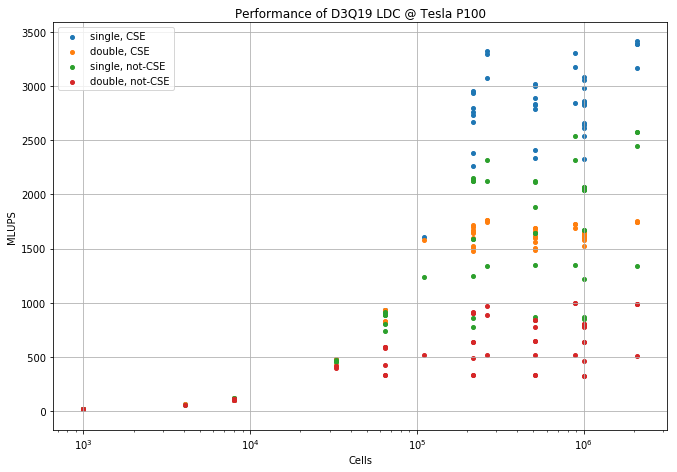

In [19]:
mlups_per_size_overview_plot(ldc_3d_D3Q19_p100, 'Performance of D3Q19 LDC @ Tesla P100')
plt.savefig('overview_d3q19_p100.pdf', bbox_inches='tight')

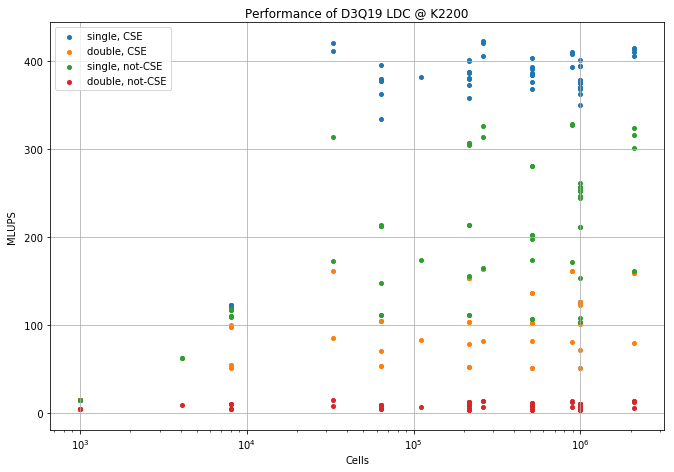

In [20]:
mlups_per_size_overview_plot(ldc_3d_D3Q19_k2200, 'Performance of D3Q19 LDC @ K2200')
plt.savefig('overview_d3q19_k2200.pdf', bbox_inches='tight')

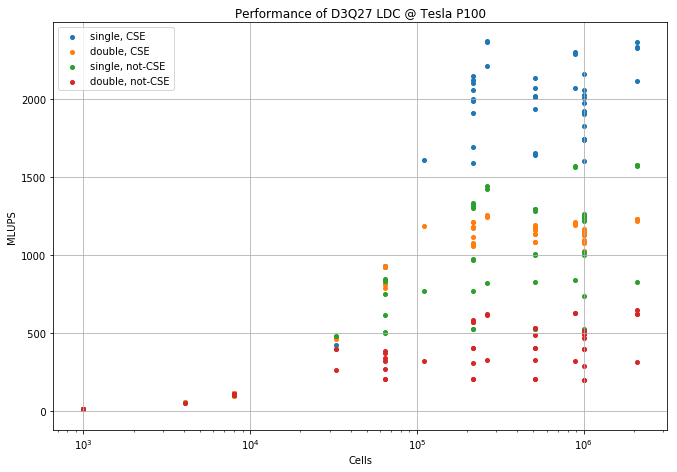

In [21]:
mlups_per_size_overview_plot(ldc_3d_D3Q27_p100, 'Performance of D3Q27 LDC @ Tesla P100')
plt.savefig('overview_d3q27_p100.pdf', bbox_inches='tight')

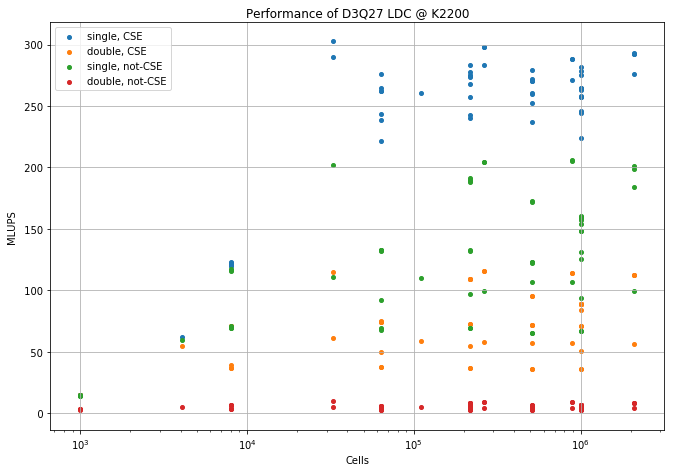

In [22]:
mlups_per_size_overview_plot(ldc_3d_D3Q27_k2200, 'Performance of D3Q27 LDC @ K2200')
plt.savefig('overview_d3q27_k2200.pdf', bbox_inches='tight')

In [23]:
def mlups_for_layout(measurement):
    return (measurement[0][1][0], numpy.average(measurement[1]))

In [24]:
def mlups_per_layout_overview_plot(data, title, **kwargs):
    plt.figure(figsize=(11,7.5))
    plt.grid()
    plt.title(title)
    plt.xscale('log')
    plt.xlabel('Thread block size')
    plt.ylabel('MLUPS')
    plt.xticks(list(map(lambda l: l[0], values(subset(data, **kwargs),1))), values(subset(data, **kwargs),1))
    scatter(map(mlups_for_layout, subset(data, precision=['single'], optimization=[True], **kwargs)), label='single, CSE')
    scatter(map(mlups_for_layout, subset(data, precision=['double'], optimization=[True], **kwargs)), label='double, CSE')
    scatter(map(mlups_for_layout, subset(data, precision=['single'], optimization=[False], **kwargs)), label='single, not-CSE')
    scatter(map(mlups_for_layout, subset(data, precision=['double'], optimization=[False], **kwargs)), label='double, not-CSE')
    plt.legend()

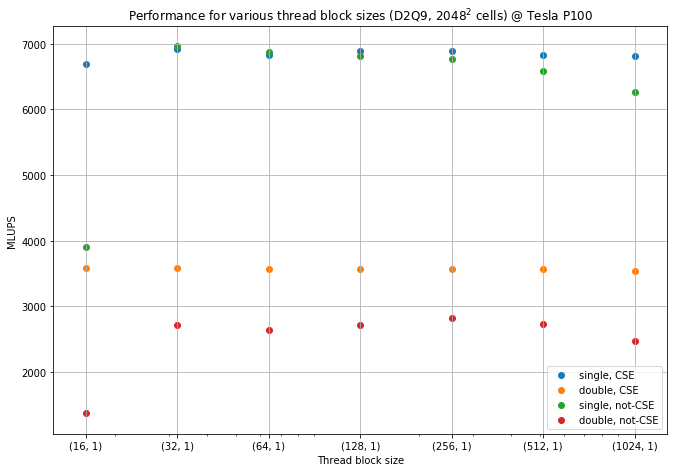

In [25]:
mlups_per_layout_overview_plot(
    ldc_2d_p100,
    'Performance for various thread block sizes (D2Q9, $2048^2$ cells) @ Tesla P100',
    size=[2048])
plt.savefig('thread_size_d2q9_n2048_p100.pdf', bbox_inches='tight')

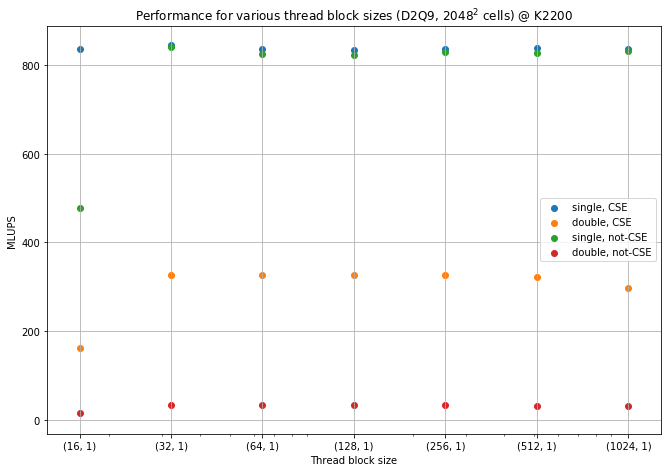

In [26]:
mlups_per_layout_overview_plot(
    ldc_2d_k2200,
    'Performance for various thread block sizes (D2Q9, $2048^2$ cells) @ K2200',
    size=[2048])
plt.savefig('thread_size_d2q9_n2048_k2200.pdf', bbox_inches='tight')

In [27]:
def mlups_per_layout_mixed_overview_plot(data, title, **kwargs):
    plt.figure(figsize=(11,7))
    plt.grid()
    plt.title(title)
    plt.xscale('log')
    plt.xlabel('Thread block size')
    plt.ylabel('MLUPS')
    plt.xticks(list(map(lambda l: l[0], values(subset(data, **kwargs),1))), values(subset(data, **kwargs),1), rotation=45)
    scatter(map(mlups_for_layout, subset(data, precision=['single'], optimization=[True], align=[True], **kwargs)), label='single, CSE')
    scatter(map(mlups_for_layout, subset(data, precision=['double'], optimization=[True], align=[True], **kwargs)), label='double, CSE')
    scatter(map(mlups_for_layout, subset(data, precision=['single'], optimization=[False], align=[True], **kwargs)), label='single, not-CSE')
    scatter(map(mlups_for_layout, subset(data, precision=['double'], optimization=[False], align=[True], **kwargs)), label='double, not-CSE')
    plt.legend()

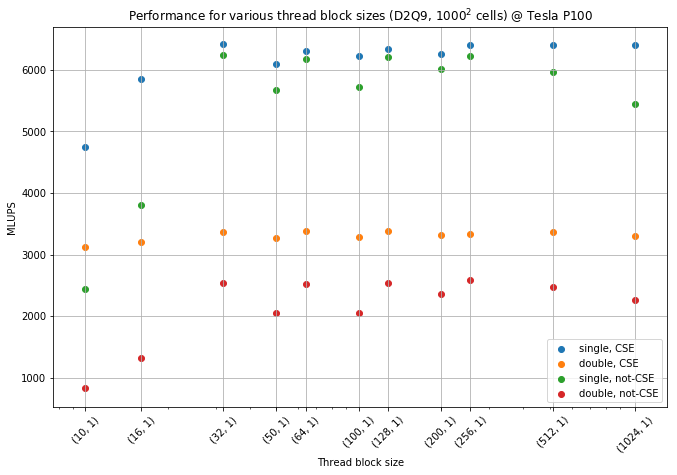

In [28]:
mlups_per_layout_mixed_overview_plot(
    ldc_2d_p100,
    'Performance for various thread block sizes (D2Q9, $1000^2$ cells) @ Tesla P100',
    size=[1000])
plt.savefig('thread_size_d2q9_n1000_p100.pdf', bbox_inches='tight')

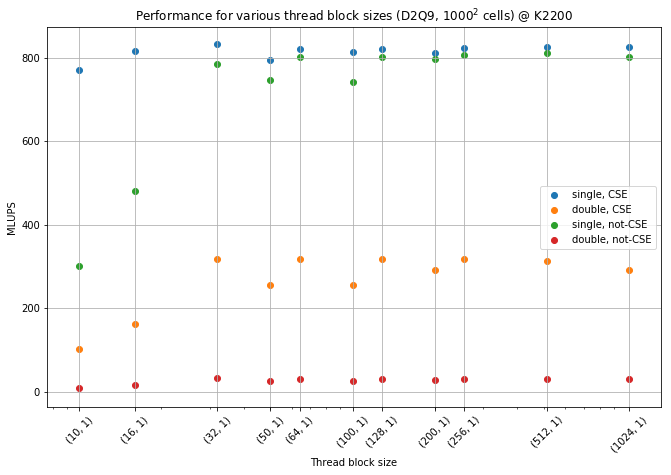

In [29]:
mlups_per_layout_mixed_overview_plot(
    ldc_2d_k2200,
    'Performance for various thread block sizes (D2Q9, $1000^2$ cells) @ K2200',
    size=[1000])
plt.savefig('thread_size_d2q9_n1000_k2200.pdf', bbox_inches='tight')

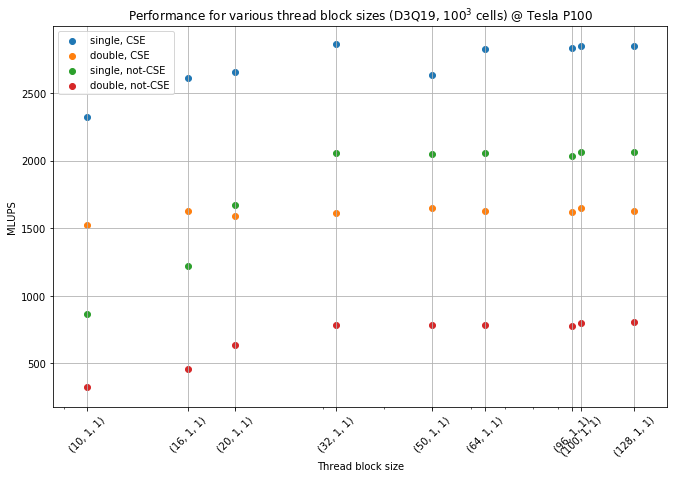

In [30]:
mlups_per_layout_mixed_overview_plot(
    ldc_3d_D3Q19_p100,
    'Performance for various thread block sizes (D3Q19, $100^3$ cells) @ Tesla P100',
    size=[100])
plt.savefig('thread_size_d3q19_n100_p100.pdf', bbox_inches='tight')

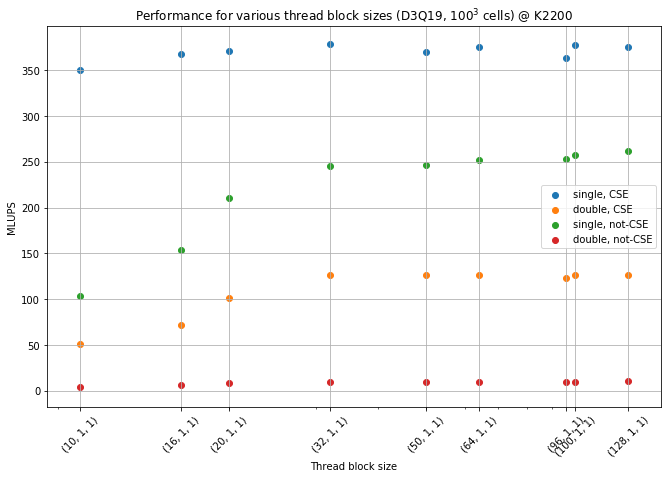

In [31]:
mlups_per_layout_mixed_overview_plot(
    ldc_3d_D3Q19_k2200,
    'Performance for various thread block sizes (D3Q19, $100^3$ cells) @ K2200',
    size=[100])
plt.savefig('thread_size_d3q19_n100_k2200.pdf', bbox_inches='tight')

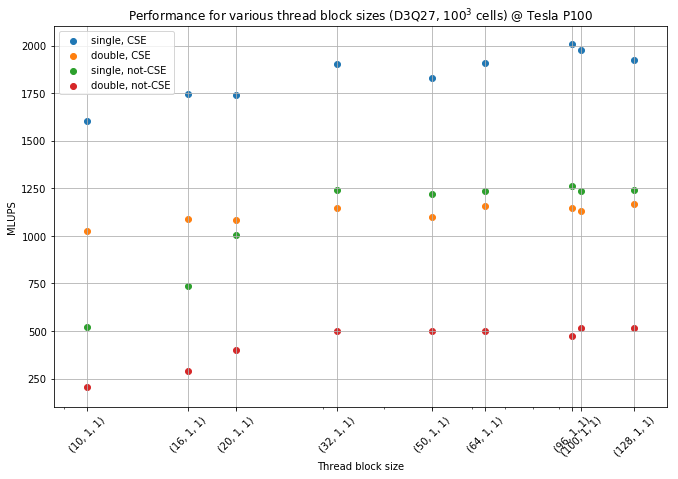

In [32]:
mlups_per_layout_mixed_overview_plot(
    ldc_3d_D3Q27_p100,
    'Performance for various thread block sizes (D3Q27, $100^3$ cells) @ Tesla P100',
    size=[100])
plt.savefig('thread_size_d3q27_n100_p100.pdf', bbox_inches='tight')

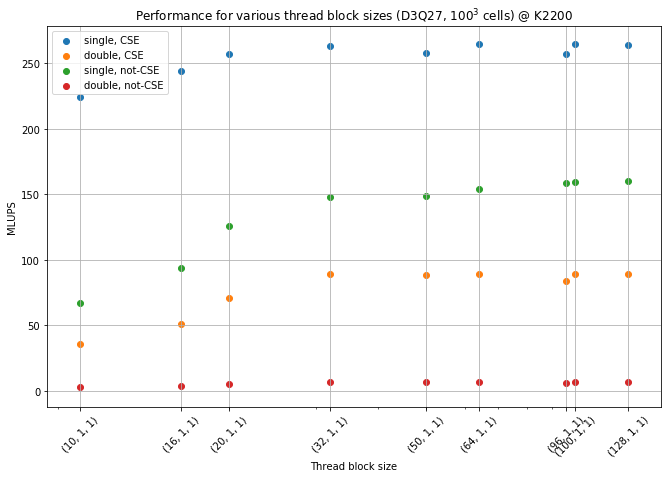

In [33]:
mlups_per_layout_mixed_overview_plot(
    ldc_3d_D3Q27_k2200,
    'Performance for various thread block sizes (D3Q27, $100^3$ cells) @ K2200',
    size=[100])
plt.savefig('thread_size_d3q27_n100_k2200.pdf', bbox_inches='tight')

In [34]:
def align_comparison_plot(data, title, **kwargs):
    plt.figure(figsize=(10,4))
    plt.grid()
    plt.title(title)
    plt.xscale('log')
    plt.xlabel('Thread block size')
    plt.ylabel('MLUPS')
    plt.xticks(list(map(lambda l: l[0], values(subset(data, **kwargs),1))), values(subset(data, **kwargs),1))
    scatter(map(mlups_for_layout, subset(data, precision=['single'], optimization=[True], align=[True], **kwargs)), label='aligned, single, CSE')
    scatter(map(mlups_for_layout, subset(data, precision=['single'], optimization=[True], align=[False], **kwargs)), label='unaligned, single, CSE')
    plt.legend()

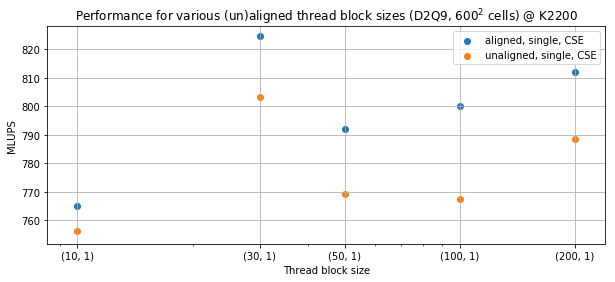

In [35]:
align_comparison_plot(
    ldc_2d_k2200,
    'Performance for various (un)aligned thread block sizes (D2Q9, $600^2$ cells) @ K2200',
    size=[600], layout=lambda x: x % 10 == 0)
plt.savefig('align_k2200.pdf', bbox_inches='tight')

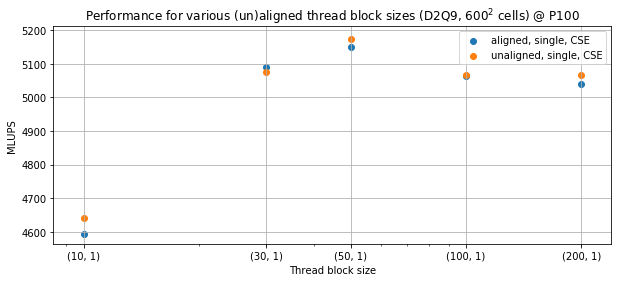

In [36]:
align_comparison_plot(
    ldc_2d_p100,
    'Performance for various (un)aligned thread block sizes (D2Q9, $600^2$ cells) @ P100',
    size=[600], layout=lambda x: x % 10 == 0)
plt.savefig('align_p100.pdf', bbox_inches='tight')

In [37]:
def mlups_spread(data, **kwargs):
    tmp = list(map(lambda m: numpy.average(m[1]), subset(data, **kwargs)))
    return (numpy.amin(tmp), numpy.amax(tmp))

In [38]:
mlups_spread(ldc_2d_p100, precision=['single'])

(13.0, 6957.4)

In [39]:
mlups_spread(ldc_2d_p100, size=[1024], precision=['single'])

(3873.2, 6728.2)

In [40]:
def spreads(data, sizes, **kwargs):
    return list(map(lambda s: mlups_spread(data, size=[s], **kwargs), sizes))

In [41]:
spreads(ldc_2d_p100, [32,64,128,512,1024])

[(13.0, 13.8),
 (56.8, 59.8),
 (213.2, 217.0),
 (1137.0, 3628.8),
 (1333.8, 6728.2)]

In [42]:
def get_dim(data):
    layouts = values(data, 1)
    return len(list(layouts)[0])

In [43]:
def mlups_per_cell_spread_plot(data, title, **kwargs):
    dim = get_dim(data)
    #widths = list(filter(lambda w: w % 10 == 0, values(data, 0)))
    widths = values(data, 0)
    sizes = list(map(lambda x: x**dim, widths))
    lines = list(zip(*spreads(data, widths, **kwargs)))
    plt.figure(figsize=(11,8))
    plt.grid()
    plt.title(title)
    plt.xscale('log')
    plt.xlabel('Cells')
    plt.ylabel('MLUPS')
    plt.vlines(sizes, ymin=lines[0], ymax=lines[1])
    plt.scatter(sizes, lines[0], marker='_', c='black')
    plt.scatter(sizes, lines[1], marker='_', c='black')

In [44]:
def max_mlups_line(gpu, q, p):
    mlups = max_mlups({
        'p100' : p100_max_bandwidth,
        'k2200': k2200_max_bandwidth
    }.get(gpu), q, {
        'single': 4,
        'double': 8
    }.get(p))
    plt.axhline(mlups, ls='--')
    
    ax = plt.gca()
    max_ax = ax.twinx()
    max_ax.set_yticks([mlups])
    max_ax.set_ylim(ax.get_ylim())

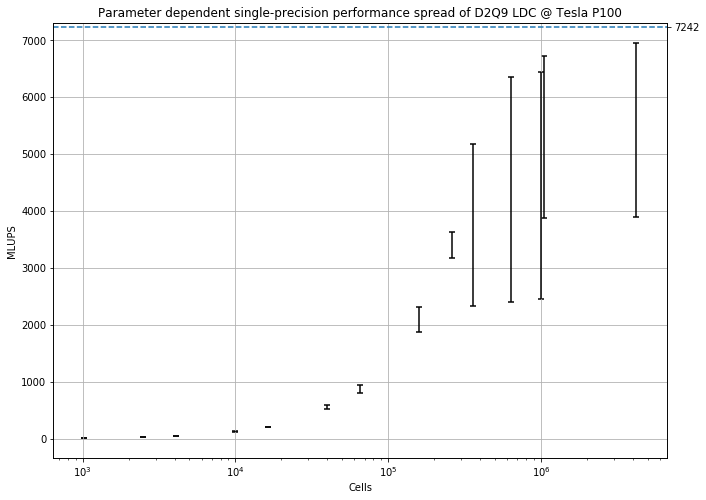

In [45]:
mlups_per_cell_spread_plot(
    ldc_2d_p100,
    'Parameter dependent single-precision performance spread of D2Q9 LDC @ Tesla P100',
    precision=['single'])
max_mlups_line('p100', 9, 'single')
plt.savefig('param_spread_single_d2q9_p100.pdf', bbox_inches='tight')

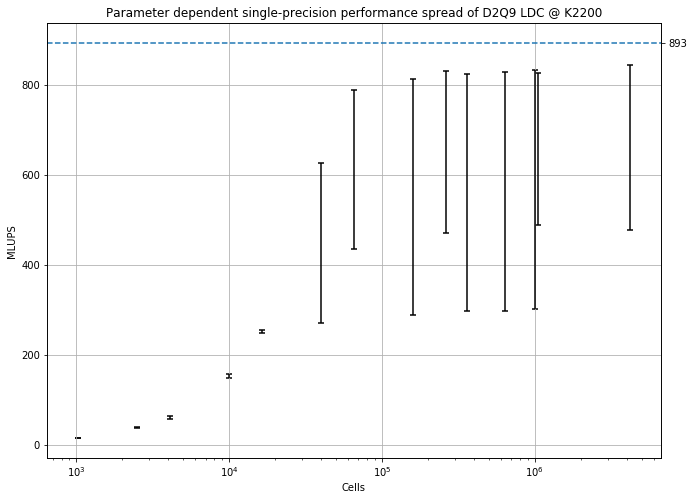

In [46]:
mlups_per_cell_spread_plot(
    ldc_2d_k2200,
    'Parameter dependent single-precision performance spread of D2Q9 LDC @ K2200',
    precision=['single'])
max_mlups_line('k2200', 9, 'single')
plt.savefig('param_spread_single_d2q9_k2200.pdf', bbox_inches='tight')

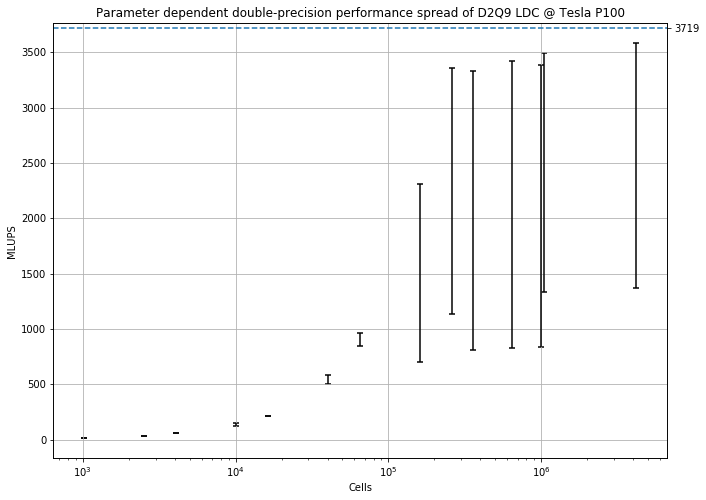

In [47]:
mlups_per_cell_spread_plot(
    ldc_2d_p100,
    'Parameter dependent double-precision performance spread of D2Q9 LDC @ Tesla P100',
    precision=['double'])
max_mlups_line('p100', 9, 'double')
plt.savefig('param_spread_double_d2q9_p100.pdf', bbox_inches='tight')

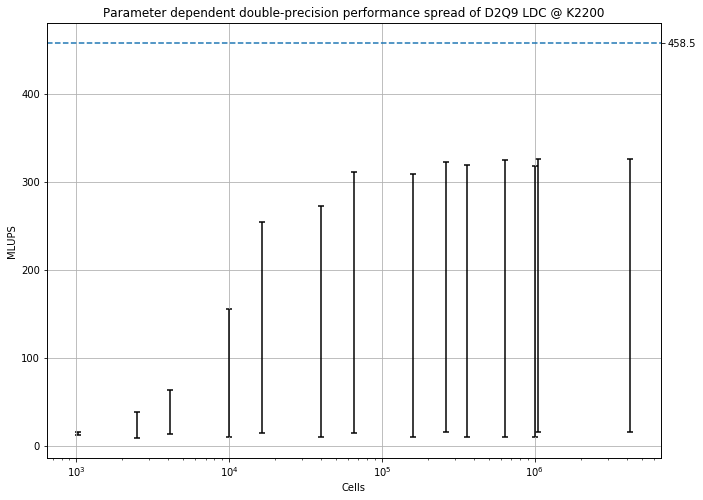

In [48]:
mlups_per_cell_spread_plot(
    ldc_2d_k2200,
    'Parameter dependent double-precision performance spread of D2Q9 LDC @ K2200',
    precision=['double'])
max_mlups_line('k2200', 9, 'double')
plt.savefig('param_spread_double_d2q9_k2200.pdf', bbox_inches='tight')

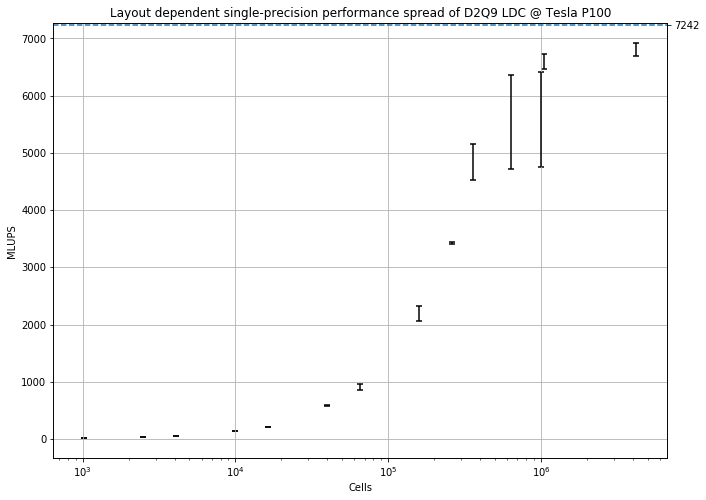

In [49]:
mlups_per_cell_spread_plot(
    ldc_2d_p100,
    'Layout dependent single-precision performance spread of D2Q9 LDC @ Tesla P100',
    precision=['single'], optimization=[True], align=[True])
max_mlups_line('p100', 9, 'single')
plt.savefig('layout_spread_single_d2q9_p100.pdf', bbox_inches='tight')

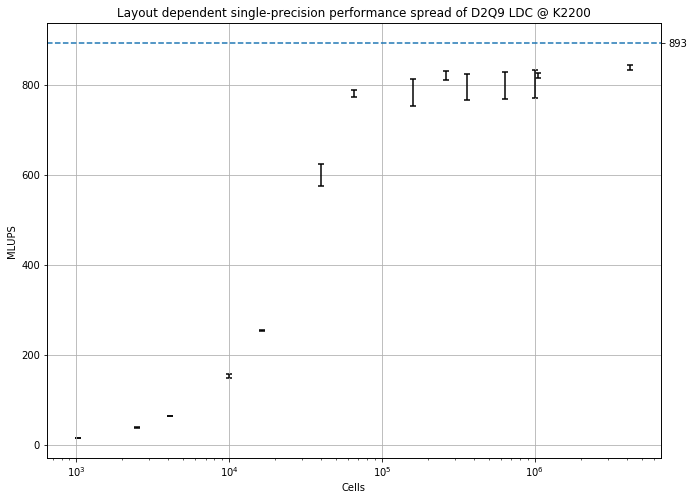

In [50]:
mlups_per_cell_spread_plot(
    ldc_2d_k2200,
    'Layout dependent single-precision performance spread of D2Q9 LDC @ K2200',
    precision=['single'], optimization=[True], align=[True])
max_mlups_line('k2200', 9, 'single')
plt.savefig('layout_spread_single_d2q9_k2200.pdf', bbox_inches='tight')

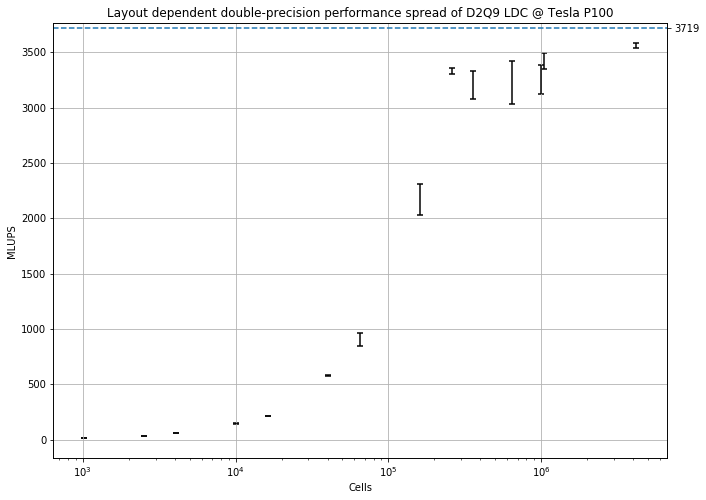

In [51]:
mlups_per_cell_spread_plot(
    ldc_2d_p100,
    'Layout dependent double-precision performance spread of D2Q9 LDC @ Tesla P100',
    precision=['double'], optimization=[True], align=[True])
max_mlups_line('p100', 9, 'double')
plt.savefig('layout_spread_double_d2q9_p100.pdf', bbox_inches='tight')

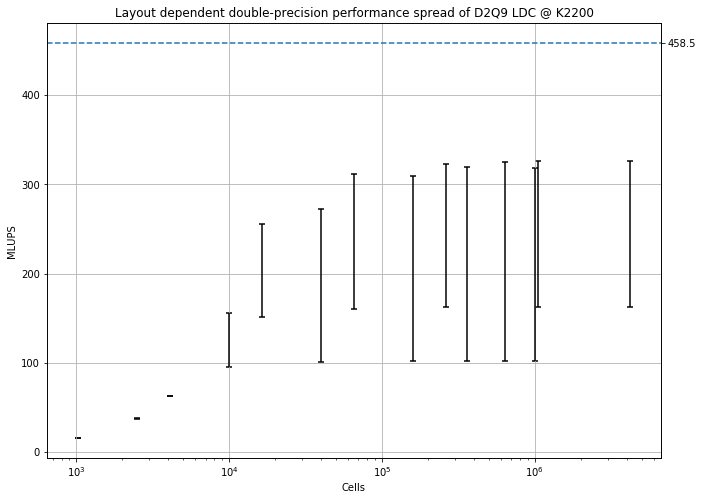

In [52]:
mlups_per_cell_spread_plot(
    ldc_2d_k2200,
    'Layout dependent double-precision performance spread of D2Q9 LDC @ K2200',
    precision=['double'], optimization=[True], align=[True])
max_mlups_line('k2200', 9, 'double')
plt.savefig('layout_spread_double_d2q9_k2200.pdf', bbox_inches='tight')

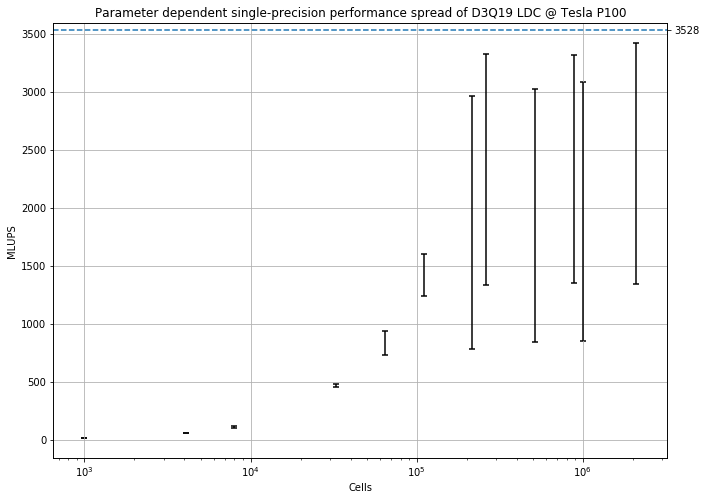

In [53]:
mlups_per_cell_spread_plot(
    ldc_3d_D3Q19_p100,
    'Parameter dependent single-precision performance spread of D3Q19 LDC @ Tesla P100',
    precision=['single'])
max_mlups_line('p100', 19, 'single')
plt.savefig('param_spread_single_d3q19_p100.pdf', bbox_inches='tight')

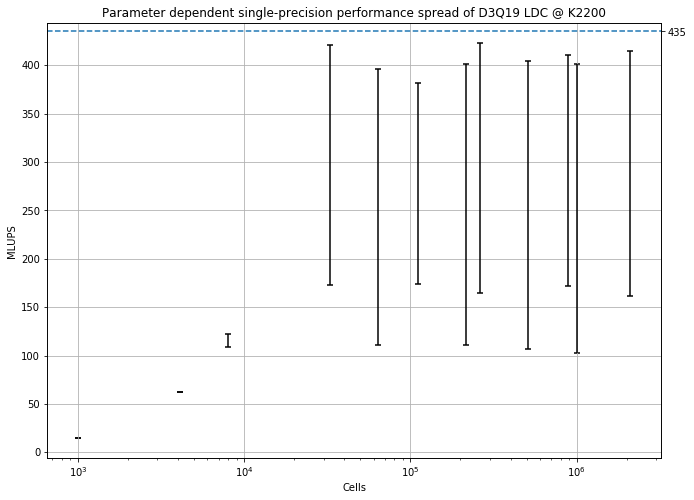

In [54]:
mlups_per_cell_spread_plot(
    ldc_3d_D3Q19_k2200,
    'Parameter dependent single-precision performance spread of D3Q19 LDC @ K2200',
    precision=['single'])
max_mlups_line('k2200', 19, 'single')
plt.savefig('param_spread_single_d3q19_k2200.pdf', bbox_inches='tight')

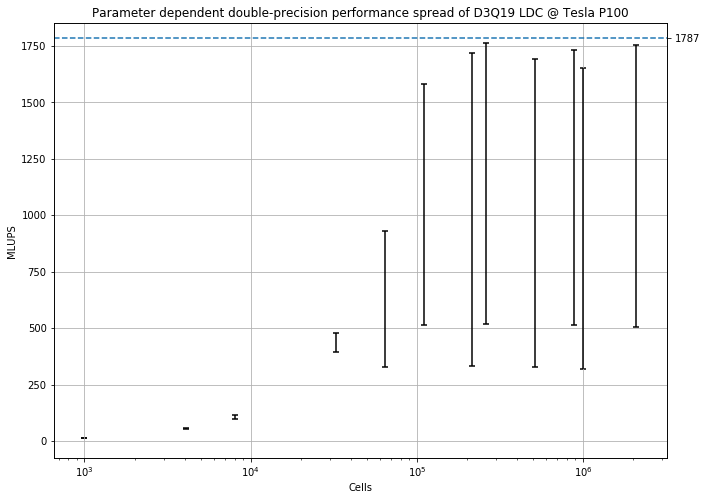

In [55]:
mlups_per_cell_spread_plot(
    ldc_3d_D3Q19_p100,
    'Parameter dependent double-precision performance spread of D3Q19 LDC @ Tesla P100',
    precision=['double'])
max_mlups_line('p100', 19, 'double')
plt.savefig('param_spread_double_d3q19_p100.pdf', bbox_inches='tight')

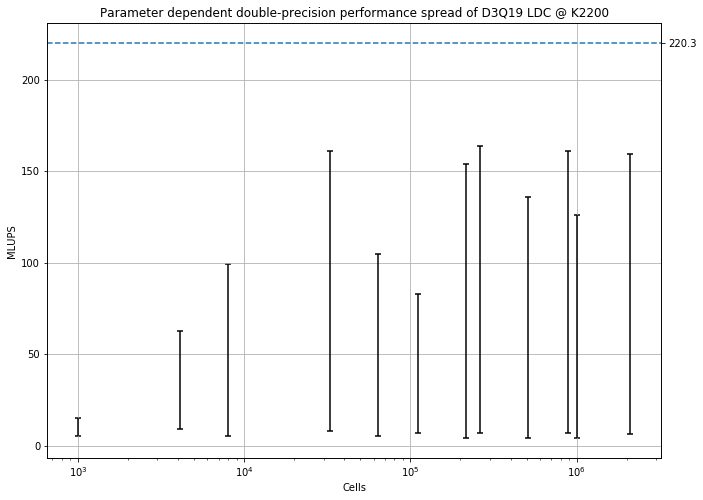

In [56]:
mlups_per_cell_spread_plot(
    ldc_3d_D3Q19_k2200,
    'Parameter dependent double-precision performance spread of D3Q19 LDC @ K2200',
    precision=['double'])
max_mlups_line('k2200', 19, 'double')
plt.savefig('param_spread_double_d3q19_k2200.pdf', bbox_inches='tight')

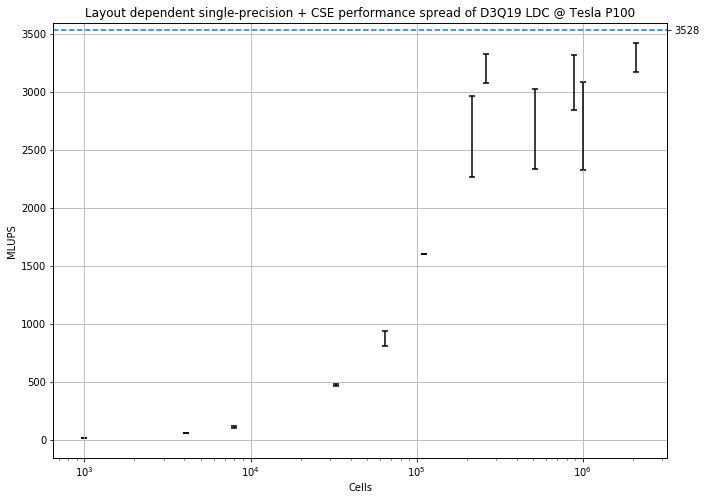

In [57]:
mlups_per_cell_spread_plot(
    ldc_3d_D3Q19_p100,
    'Layout dependent single-precision + CSE performance spread of D3Q19 LDC @ Tesla P100',
    precision=['single'], optimization=[True])
max_mlups_line('p100', 19, 'single')
plt.savefig('layout_spread_single_d3q19_p100.pdf', bbox_inches='tight')

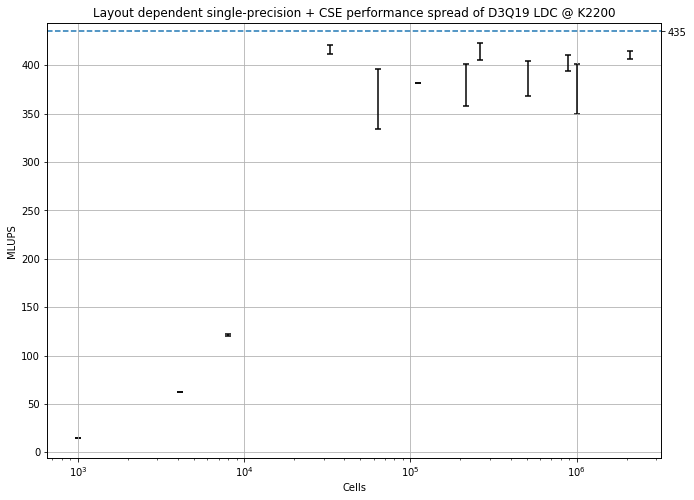

In [58]:
mlups_per_cell_spread_plot(
    ldc_3d_D3Q19_k2200,
    'Layout dependent single-precision + CSE performance spread of D3Q19 LDC @ K2200',
    precision=['single'], optimization=[True])
max_mlups_line('k2200', 19, 'single')
plt.savefig('layout_spread_single_d3q19_k2200.pdf', bbox_inches='tight')

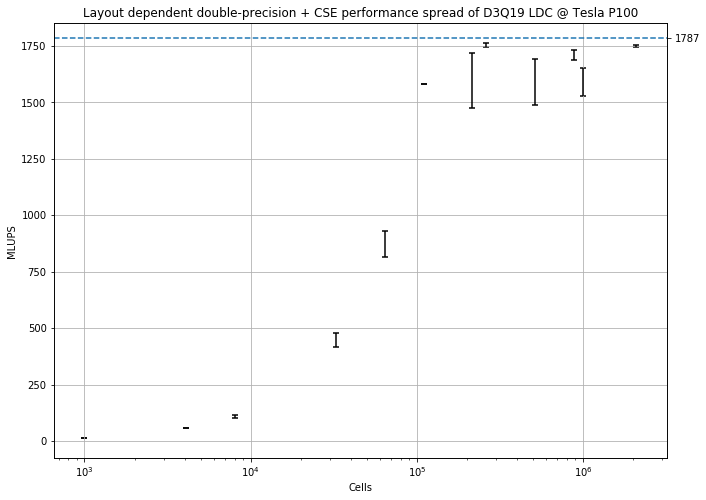

In [59]:
mlups_per_cell_spread_plot(
    ldc_3d_D3Q19_p100,
    'Layout dependent double-precision + CSE performance spread of D3Q19 LDC @ Tesla P100',
    precision=['double'], optimization=[True])
max_mlups_line('p100', 19, 'double')
plt.savefig('layout_spread_double_d3q19_p100.pdf', bbox_inches='tight')

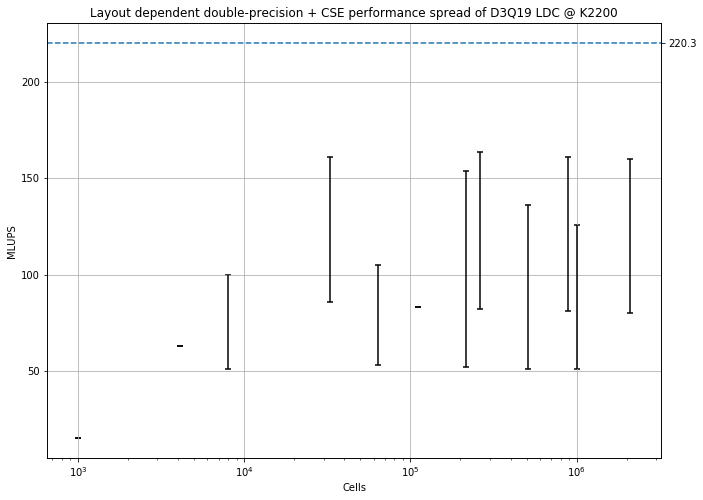

In [60]:
mlups_per_cell_spread_plot(
    ldc_3d_D3Q19_k2200,
    'Layout dependent double-precision + CSE performance spread of D3Q19 LDC @ K2200',
    precision=['double'], optimization=[True])
max_mlups_line('k2200', 19, 'double')
plt.savefig('layout_spread_double_d3q19_k2200.pdf', bbox_inches='tight')

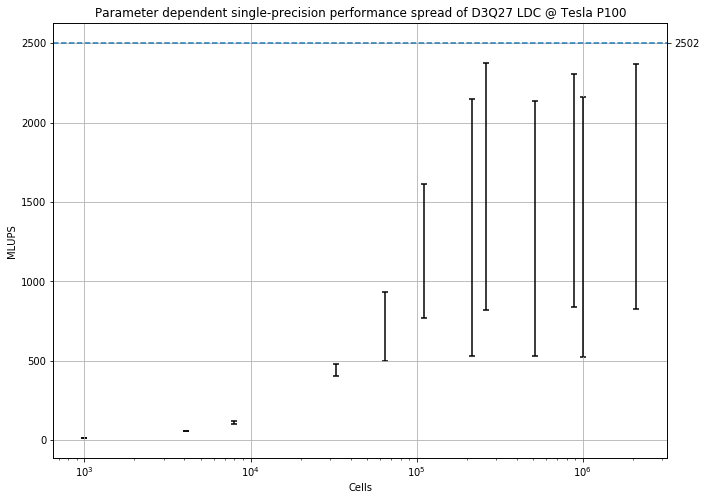

In [61]:
mlups_per_cell_spread_plot(
    ldc_3d_D3Q27_p100,
    'Parameter dependent single-precision performance spread of D3Q27 LDC @ Tesla P100',
    precision=['single'])
max_mlups_line('p100', 27, 'single')
plt.savefig('param_spread_single_d3q27_p100.pdf', bbox_inches='tight')

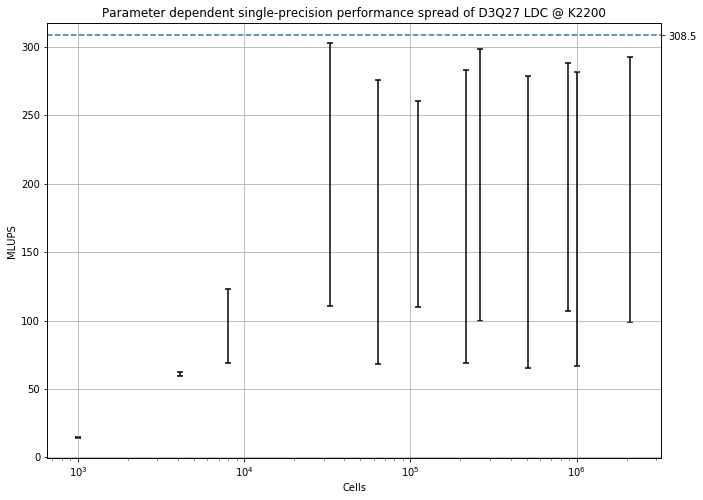

In [62]:
mlups_per_cell_spread_plot(
    ldc_3d_D3Q27_k2200,
    'Parameter dependent single-precision performance spread of D3Q27 LDC @ K2200',
    precision=['single'])
max_mlups_line('k2200', 27, 'single')
plt.savefig('param_spread_single_d3q27_k2200.pdf', bbox_inches='tight')

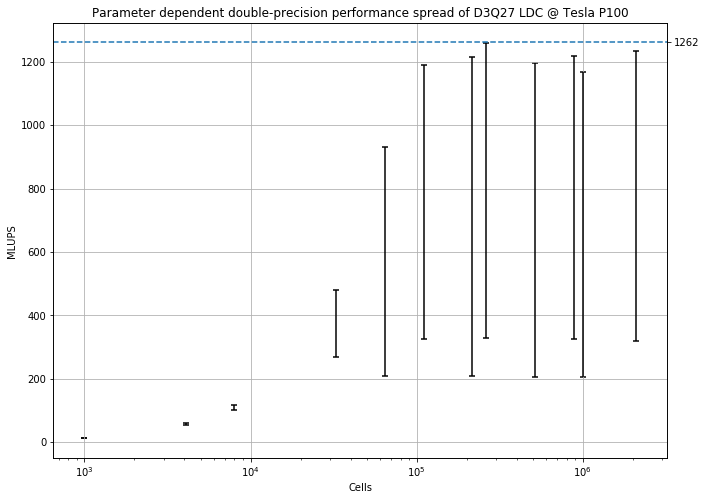

In [63]:
mlups_per_cell_spread_plot(
    ldc_3d_D3Q27_p100,
    'Parameter dependent double-precision performance spread of D3Q27 LDC @ Tesla P100',
    precision=['double'])
max_mlups_line('p100', 27, 'double')
plt.savefig('param_spread_double_d3q27_p100.pdf', bbox_inches='tight')

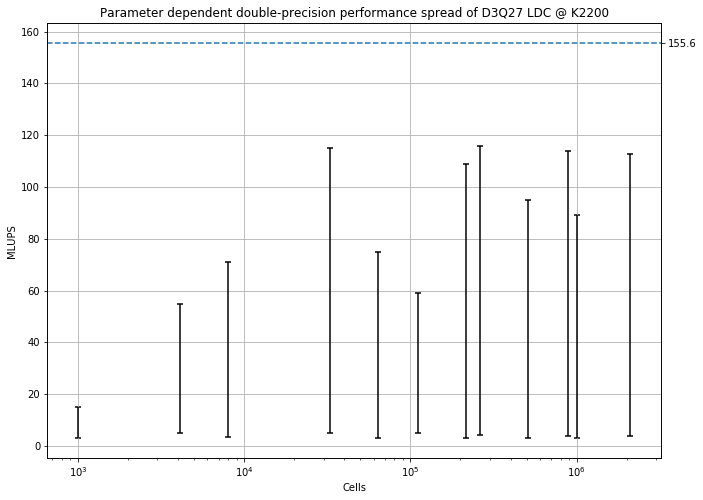

In [64]:
mlups_per_cell_spread_plot(
    ldc_3d_D3Q27_k2200,
    'Parameter dependent double-precision performance spread of D3Q27 LDC @ K2200',
    precision=['double'])
max_mlups_line('k2200', 27, 'double')
plt.savefig('param_spread_double_d3q27_k2200.pdf', bbox_inches='tight')

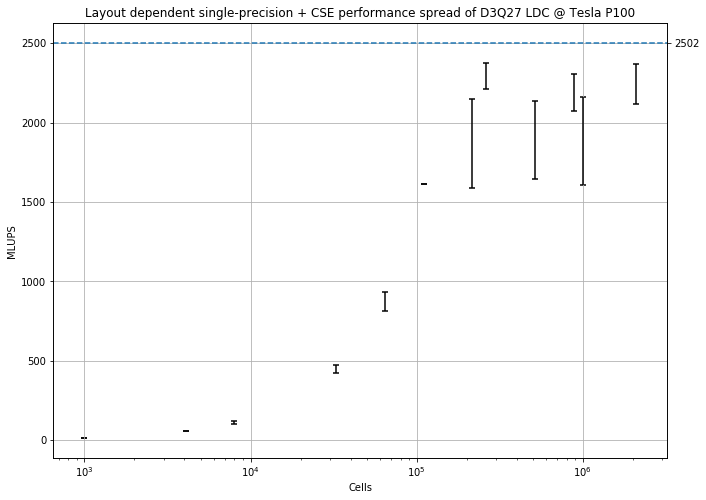

In [65]:
mlups_per_cell_spread_plot(
    ldc_3d_D3Q27_p100,
    'Layout dependent single-precision + CSE performance spread of D3Q27 LDC @ Tesla P100',
    precision=['single'], optimization=[True])
max_mlups_line('p100', 27, 'single')
plt.savefig('layout_spread_single_d3q27_p100.pdf', bbox_inches='tight')

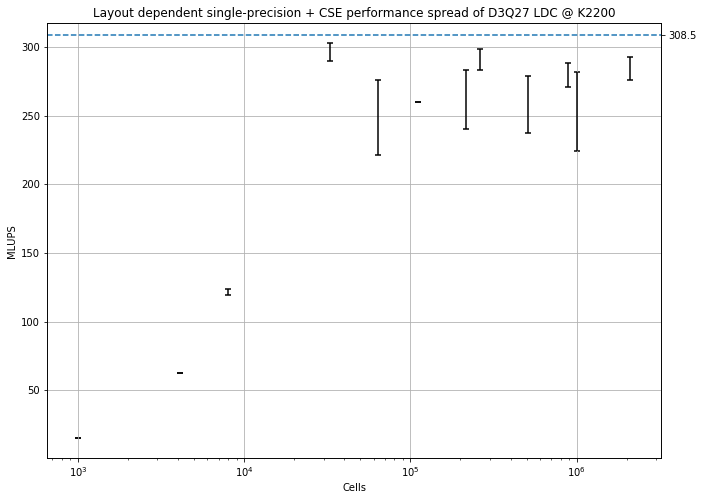

In [66]:
mlups_per_cell_spread_plot(
    ldc_3d_D3Q27_k2200,
    'Layout dependent single-precision + CSE performance spread of D3Q27 LDC @ K2200',
    precision=['single'], optimization=[True])
max_mlups_line('k2200', 27, 'single')
plt.savefig('layout_spread_single_d3q27_k2200.pdf', bbox_inches='tight')

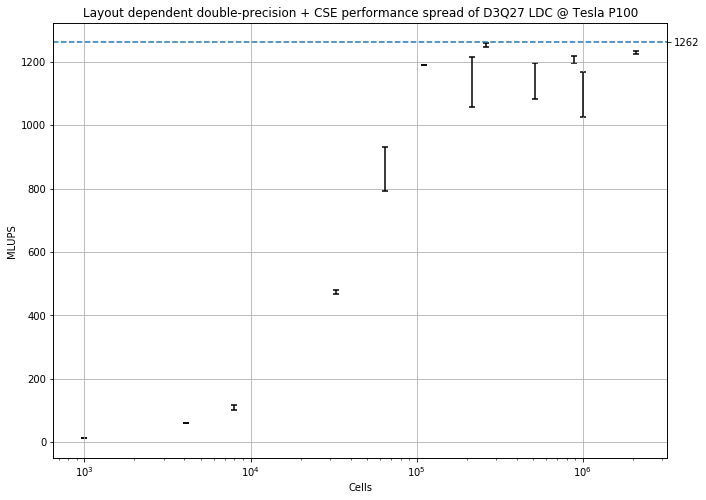

In [67]:
mlups_per_cell_spread_plot(
    ldc_3d_D3Q27_p100,
    'Layout dependent double-precision + CSE performance spread of D3Q27 LDC @ Tesla P100',
    precision=['double'], optimization=[True])
max_mlups_line('p100', 27, 'double')
plt.savefig('layout_spread_double_d3q27_p100.pdf', bbox_inches='tight')

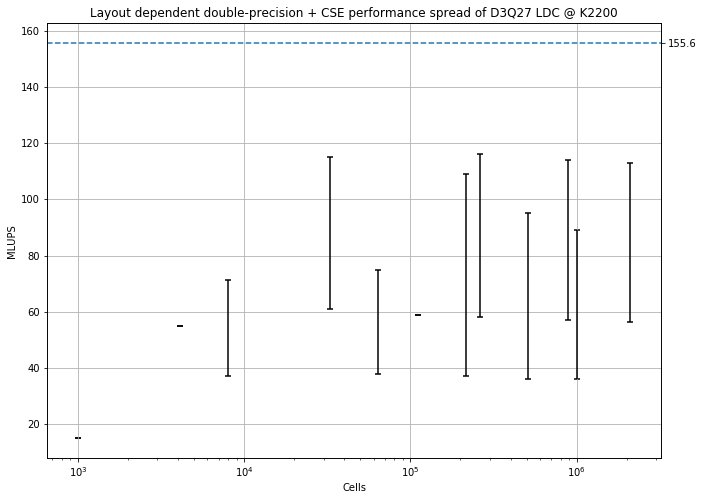

In [68]:
mlups_per_cell_spread_plot(
    ldc_3d_D3Q27_k2200,
    'Layout dependent double-precision + CSE performance spread of D3Q27 LDC @ K2200',
    precision=['double'], optimization=[True])
max_mlups_line('k2200', 27, 'double')
plt.savefig('layout_spread_double_d3q27_k2200.pdf', bbox_inches='tight')